In [4]:
import torch
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from DataCollector import DataCollector
from resnet_model import *

In [5]:
# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Fetching Dataset
df = DataCollector(dataset="CIFAR10", batch_size=128)
df.add_Horizontal_Flip()
df.add_Random_Crop(size=32, padding=4)
df.add_Normalizer()
trainLoader, testLoader = df.fetch_Loaders()

Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:02<00:00, 67521550.49it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Get Model
model = resnet_model()
model = model.to(device)
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,248
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,248
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,496
      BatchNorm2d-14           [-1, 64,

In [8]:
# Setting up training
EPOCHS=250
globalBestAccuracy = 0.0
training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []

In [9]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer) 
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.1
weightDecay = 0.0001

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)

print(model.eval())

trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))

if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [10]:
# Training
for i in tqdm(range(EPOCHS)):
    
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model.train()
            optimizer.zero_grad()
        else:
            loader = testLoader
            model.eval()

        cumulativeLoss = 0.0
        cumulativeCorrects = 0
        
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = lossFunction(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            #cumulativeLoss += loss.item()*images.size(0)
            cumulativeLoss += loss.item()
            cumulativeCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":
                loss.backward()
                optimizer.step()
        
        epoch_loss = cumulativeLoss/len(loader.dataset)
        epoch_accuracy = cumulativeCorrects/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            training_loss.append(epoch_loss)
            training_accuracy.append(epoch_accuracy)
        else:
            testing_loss.append(epoch_loss)
            testing_accuracy.append(epoch_accuracy)
            if epoch_accuracy > globalBestAccuracy:
                globalBestAccuracy = epoch_accuracy
                model.saveToDisk()

    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(training_loss[-1], testing_loss[-1], training_accuracy[-1], testing_accuracy[-1]))

  0%|          | 1/250 [00:28<1:59:38, 28.83s/it]

Training Loss : 1.6999342614746094, Testing Loss : 1.580710736656189, Training Accuracy : 0.35854, Testing Accuracy : 0.4118


  1%|          | 2/250 [00:56<1:55:49, 28.02s/it]

Training Loss : 1.430318461151123, Testing Loss : 1.3387130104064942, Training Accuracy : 0.47248, Testing Accuracy : 0.5136


  1%|          | 3/250 [01:23<1:54:14, 27.75s/it]

Training Loss : 1.2190800297546387, Testing Loss : 1.1328241428375243, Training Accuracy : 0.55478, Testing Accuracy : 0.5936


  2%|▏         | 4/250 [01:51<1:53:29, 27.68s/it]

Training Loss : 1.072094352874756, Testing Loss : 1.07316948261261, Training Accuracy : 0.61302, Testing Accuracy : 0.6197


  2%|▏         | 5/250 [02:18<1:52:06, 27.46s/it]

Training Loss : 0.9620511212158203, Testing Loss : 0.9510268716812134, Training Accuracy : 0.6555, Testing Accuracy : 0.672


  2%|▏         | 6/250 [02:45<1:51:33, 27.43s/it]

Training Loss : 0.876687712097168, Testing Loss : 0.9079638812065125, Training Accuracy : 0.69032, Testing Accuracy : 0.6854


  3%|▎         | 7/250 [03:13<1:50:57, 27.40s/it]

Training Loss : 0.8014247357177734, Testing Loss : 0.831079282951355, Training Accuracy : 0.71952, Testing Accuracy : 0.7109


  3%|▎         | 8/250 [03:39<1:49:46, 27.22s/it]

Training Loss : 0.7283114044952392, Testing Loss : 0.7527303636550904, Training Accuracy : 0.74662, Testing Accuracy : 0.7417


  4%|▎         | 9/250 [04:07<1:49:15, 27.20s/it]

Training Loss : 0.6800666033172608, Testing Loss : 0.7294592747688293, Training Accuracy : 0.76268, Testing Accuracy : 0.7477


  4%|▍         | 10/250 [04:34<1:48:50, 27.21s/it]

Training Loss : 0.6393723736572265, Testing Loss : 0.7132607544422149, Training Accuracy : 0.7797, Testing Accuracy : 0.7619


  4%|▍         | 11/250 [05:01<1:48:36, 27.27s/it]

Training Loss : 0.6176538452148438, Testing Loss : 0.6627093379020691, Training Accuracy : 0.78776, Testing Accuracy : 0.7748


  5%|▍         | 12/250 [05:28<1:47:58, 27.22s/it]

Training Loss : 0.5728378158569336, Testing Loss : 0.6128238918304444, Training Accuracy : 0.80128, Testing Accuracy : 0.7889


  5%|▌         | 13/250 [05:56<1:47:55, 27.32s/it]

Training Loss : 0.5428495859527588, Testing Loss : 0.6241217704296113, Training Accuracy : 0.81244, Testing Accuracy : 0.7883


  6%|▌         | 14/250 [06:24<1:48:24, 27.56s/it]

Training Loss : 0.5072183083343506, Testing Loss : 0.5877093003273011, Training Accuracy : 0.82396, Testing Accuracy : 0.7967


  6%|▌         | 15/250 [06:51<1:47:41, 27.50s/it]

Training Loss : 0.4988124430847168, Testing Loss : 0.5633865377902985, Training Accuracy : 0.82542, Testing Accuracy : 0.8064


  6%|▋         | 16/250 [07:19<1:46:54, 27.41s/it]

Training Loss : 0.46997950225830076, Testing Loss : 0.5849822025775909, Training Accuracy : 0.83854, Testing Accuracy : 0.8071


  7%|▋         | 17/250 [07:46<1:46:08, 27.33s/it]

Training Loss : 0.45388798671722413, Testing Loss : 0.5936066109657288, Training Accuracy : 0.84376, Testing Accuracy : 0.802


  7%|▋         | 18/250 [08:13<1:45:38, 27.32s/it]

Training Loss : 0.4588190990447998, Testing Loss : 0.5612855259895325, Training Accuracy : 0.84098, Testing Accuracy : 0.8144


  8%|▊         | 19/250 [08:40<1:45:06, 27.30s/it]

Training Loss : 0.43614904666900634, Testing Loss : 0.584981456565857, Training Accuracy : 0.8496, Testing Accuracy : 0.8019


  8%|▊         | 20/250 [09:07<1:44:29, 27.26s/it]

Training Loss : 0.4238687473297119, Testing Loss : 0.534206537437439, Training Accuracy : 0.85362, Testing Accuracy : 0.8237


  8%|▊         | 21/250 [09:35<1:44:47, 27.46s/it]

Training Loss : 0.3979254330444336, Testing Loss : 0.493718018245697, Training Accuracy : 0.8633, Testing Accuracy : 0.8359


  9%|▉         | 22/250 [10:03<1:44:06, 27.40s/it]

Training Loss : 0.37269694831848144, Testing Loss : 0.4871657898902893, Training Accuracy : 0.87248, Testing Accuracy : 0.8377


  9%|▉         | 23/250 [10:30<1:43:24, 27.33s/it]

Training Loss : 0.3577816873550415, Testing Loss : 0.48031956977844237, Training Accuracy : 0.8775, Testing Accuracy : 0.8439


 10%|▉         | 24/250 [10:57<1:42:28, 27.20s/it]

Training Loss : 0.3554678807449341, Testing Loss : 0.5222720067024231, Training Accuracy : 0.87594, Testing Accuracy : 0.8324


 10%|█         | 25/250 [11:24<1:42:24, 27.31s/it]

Training Loss : 0.3580586828041077, Testing Loss : 0.5022817036151886, Training Accuracy : 0.87674, Testing Accuracy : 0.8351


 10%|█         | 26/250 [11:51<1:41:38, 27.23s/it]

Training Loss : 0.3425825684738159, Testing Loss : 0.47779933314323425, Training Accuracy : 0.8827, Testing Accuracy : 0.8421


 11%|█         | 27/250 [12:20<1:42:43, 27.64s/it]

Training Loss : 0.32433860473632814, Testing Loss : 0.47463815274238585, Training Accuracy : 0.88794, Testing Accuracy : 0.8468


 11%|█         | 28/250 [12:48<1:42:22, 27.67s/it]

Training Loss : 0.31445753406524657, Testing Loss : 0.482687122797966, Training Accuracy : 0.89092, Testing Accuracy : 0.839


 12%|█▏        | 29/250 [13:15<1:41:41, 27.61s/it]

Training Loss : 0.31971112232208254, Testing Loss : 0.4585227482795715, Training Accuracy : 0.8901, Testing Accuracy : 0.8509


 12%|█▏        | 30/250 [13:42<1:40:36, 27.44s/it]

Training Loss : 0.2982384733963013, Testing Loss : 0.46143569803237916, Training Accuracy : 0.89794, Testing Accuracy : 0.8484


 12%|█▏        | 31/250 [14:09<1:39:22, 27.23s/it]

Training Loss : 0.28906781047821045, Testing Loss : 0.4687067708015442, Training Accuracy : 0.90054, Testing Accuracy : 0.8484


 13%|█▎        | 32/250 [14:36<1:39:02, 27.26s/it]

Training Loss : 0.2783830004310608, Testing Loss : 0.44028664512634275, Training Accuracy : 0.90446, Testing Accuracy : 0.8573


 13%|█▎        | 33/250 [15:03<1:38:27, 27.23s/it]

Training Loss : 0.2710530812835693, Testing Loss : 0.4618975333213806, Training Accuracy : 0.90538, Testing Accuracy : 0.8556


 14%|█▎        | 34/250 [15:30<1:37:41, 27.14s/it]

Training Loss : 0.2713662324142456, Testing Loss : 0.4426531520843506, Training Accuracy : 0.90546, Testing Accuracy : 0.8563


 14%|█▍        | 35/250 [15:58<1:38:00, 27.35s/it]

Training Loss : 0.26676804054260256, Testing Loss : 0.44930533933639527, Training Accuracy : 0.90738, Testing Accuracy : 0.8579


 14%|█▍        | 36/250 [16:25<1:37:12, 27.25s/it]

Training Loss : 0.256831727104187, Testing Loss : 0.4602551393985748, Training Accuracy : 0.91024, Testing Accuracy : 0.8537


 15%|█▍        | 37/250 [16:52<1:36:19, 27.13s/it]

Training Loss : 0.2555471469116211, Testing Loss : 0.4404824622154236, Training Accuracy : 0.91046, Testing Accuracy : 0.8627


 15%|█▌        | 38/250 [17:19<1:35:45, 27.10s/it]

Training Loss : 0.23401395709991454, Testing Loss : 0.4259783984184265, Training Accuracy : 0.91906, Testing Accuracy : 0.8673


 16%|█▌        | 39/250 [17:46<1:35:07, 27.05s/it]

Training Loss : 0.24104857013702394, Testing Loss : 0.44189546775817873, Training Accuracy : 0.91526, Testing Accuracy : 0.8647


 16%|█▌        | 40/250 [18:13<1:34:38, 27.04s/it]

Training Loss : 0.23899986949920654, Testing Loss : 0.4307652404308319, Training Accuracy : 0.91686, Testing Accuracy : 0.8675


 16%|█▋        | 41/250 [18:40<1:34:09, 27.03s/it]

Training Loss : 0.2167238144683838, Testing Loss : 0.44408671598434446, Training Accuracy : 0.92448, Testing Accuracy : 0.8639


 17%|█▋        | 42/250 [19:07<1:34:05, 27.14s/it]

Training Loss : 0.21770772607803346, Testing Loss : 0.44362940694093705, Training Accuracy : 0.9244, Testing Accuracy : 0.8691


 17%|█▋        | 43/250 [19:35<1:34:18, 27.34s/it]

Training Loss : 0.22545154890060426, Testing Loss : 0.4329226619243622, Training Accuracy : 0.9211, Testing Accuracy : 0.8673


 18%|█▊        | 44/250 [20:02<1:33:25, 27.21s/it]

Training Loss : 0.21493069063186646, Testing Loss : 0.42745655765533447, Training Accuracy : 0.9254, Testing Accuracy : 0.8667


 18%|█▊        | 45/250 [20:29<1:32:41, 27.13s/it]

Training Loss : 0.20995179655075072, Testing Loss : 0.47394338111877443, Training Accuracy : 0.928, Testing Accuracy : 0.8641


 18%|█▊        | 46/250 [20:56<1:31:58, 27.05s/it]

Training Loss : 0.2124585700035095, Testing Loss : 0.44633828315734864, Training Accuracy : 0.9267, Testing Accuracy : 0.8677


 19%|█▉        | 47/250 [21:23<1:31:28, 27.04s/it]

Training Loss : 0.19806008005142212, Testing Loss : 0.4590918416023254, Training Accuracy : 0.93146, Testing Accuracy : 0.8666


 19%|█▉        | 48/250 [21:51<1:31:55, 27.30s/it]

Training Loss : 0.19892900533676147, Testing Loss : 0.44688457498550416, Training Accuracy : 0.93064, Testing Accuracy : 0.8643


 20%|█▉        | 49/250 [22:18<1:31:02, 27.18s/it]

Training Loss : 0.19959027584075928, Testing Loss : 0.49163210229873655, Training Accuracy : 0.9309, Testing Accuracy : 0.8642


 20%|██        | 50/250 [22:46<1:31:32, 27.46s/it]

Training Loss : 0.1926775426864624, Testing Loss : 0.41354765224456785, Training Accuracy : 0.93444, Testing Accuracy : 0.8775


 20%|██        | 51/250 [23:13<1:30:24, 27.26s/it]

Training Loss : 0.19011490156173705, Testing Loss : 0.49069736914634704, Training Accuracy : 0.93326, Testing Accuracy : 0.8634


 21%|██        | 52/250 [23:39<1:29:35, 27.15s/it]

Training Loss : 0.19038324675559998, Testing Loss : 0.4479250950813293, Training Accuracy : 0.9341, Testing Accuracy : 0.8727


 21%|██        | 53/250 [24:06<1:28:54, 27.08s/it]

Training Loss : 0.17211774834632873, Testing Loss : 0.4539000315666199, Training Accuracy : 0.9397, Testing Accuracy : 0.8699


 22%|██▏       | 54/250 [24:33<1:28:16, 27.02s/it]

Training Loss : 0.17272792048454286, Testing Loss : 0.4318865720748901, Training Accuracy : 0.9393, Testing Accuracy : 0.873


 22%|██▏       | 55/250 [25:00<1:27:37, 26.96s/it]

Training Loss : 0.1705488366317749, Testing Loss : 0.43878814449310305, Training Accuracy : 0.9402, Testing Accuracy : 0.878


 22%|██▏       | 56/250 [25:28<1:27:37, 27.10s/it]

Training Loss : 0.16538445826530457, Testing Loss : 0.43885819544792176, Training Accuracy : 0.9414, Testing Accuracy : 0.8832


 23%|██▎       | 57/250 [25:55<1:27:43, 27.27s/it]

Training Loss : 0.16153534014701842, Testing Loss : 0.44943658471107484, Training Accuracy : 0.9432, Testing Accuracy : 0.8724


 23%|██▎       | 58/250 [26:23<1:27:27, 27.33s/it]

Training Loss : 0.15388728726387024, Testing Loss : 0.4675134392738342, Training Accuracy : 0.9457, Testing Accuracy : 0.8789


 24%|██▎       | 59/250 [26:49<1:26:27, 27.16s/it]

Training Loss : 0.1528896463060379, Testing Loss : 0.4245257868528366, Training Accuracy : 0.9463, Testing Accuracy : 0.8843


 24%|██▍       | 60/250 [27:16<1:25:14, 26.92s/it]

Training Loss : 0.14718342833518983, Testing Loss : 0.46414847450256347, Training Accuracy : 0.9487, Testing Accuracy : 0.8842


 24%|██▍       | 61/250 [27:43<1:24:45, 26.90s/it]

Training Loss : 0.1532910427904129, Testing Loss : 0.45262833362817767, Training Accuracy : 0.94568, Testing Accuracy : 0.8755


 25%|██▍       | 62/250 [28:09<1:24:03, 26.83s/it]

Training Loss : 0.15535095026969908, Testing Loss : 0.46380843443870545, Training Accuracy : 0.94566, Testing Accuracy : 0.8798


 25%|██▌       | 63/250 [28:36<1:23:37, 26.83s/it]

Training Loss : 0.13973226662635804, Testing Loss : 0.45222528772354126, Training Accuracy : 0.9507, Testing Accuracy : 0.8827


 26%|██▌       | 64/250 [29:03<1:22:53, 26.74s/it]

Training Loss : 0.14653777932167053, Testing Loss : 0.4435462862968445, Training Accuracy : 0.94824, Testing Accuracy : 0.884


 26%|██▌       | 65/250 [29:29<1:22:31, 26.76s/it]

Training Loss : 0.1354484743499756, Testing Loss : 0.4831830209732056, Training Accuracy : 0.9524, Testing Accuracy : 0.8796


 26%|██▋       | 66/250 [29:56<1:22:12, 26.81s/it]

Training Loss : 0.13842565406799318, Testing Loss : 0.5023544229507446, Training Accuracy : 0.94934, Testing Accuracy : 0.869


 27%|██▋       | 67/250 [30:24<1:22:55, 27.19s/it]

Training Loss : 0.1452982128572464, Testing Loss : 0.456816313791275, Training Accuracy : 0.94838, Testing Accuracy : 0.8793


 27%|██▋       | 68/250 [30:51<1:22:05, 27.06s/it]

Training Loss : 0.1344534524536133, Testing Loss : 0.4619296088695526, Training Accuracy : 0.95322, Testing Accuracy : 0.8832


 28%|██▊       | 69/250 [31:18<1:21:37, 27.06s/it]

Training Loss : 0.13541592891693116, Testing Loss : 0.4621382709503174, Training Accuracy : 0.95328, Testing Accuracy : 0.8776


 28%|██▊       | 70/250 [31:46<1:22:11, 27.40s/it]

Training Loss : 0.1318882324886322, Testing Loss : 0.47452468395233155, Training Accuracy : 0.95384, Testing Accuracy : 0.8816


 28%|██▊       | 71/250 [32:13<1:21:10, 27.21s/it]

Training Loss : 0.13034846102237702, Testing Loss : 0.45608714084625246, Training Accuracy : 0.95476, Testing Accuracy : 0.8769


 29%|██▉       | 72/250 [32:40<1:20:18, 27.07s/it]

Training Loss : 0.12765427477359773, Testing Loss : 0.47118546628952024, Training Accuracy : 0.9555, Testing Accuracy : 0.8823


 29%|██▉       | 73/250 [33:07<1:19:42, 27.02s/it]

Training Loss : 0.11399916299819947, Testing Loss : 0.4309807978630066, Training Accuracy : 0.9599, Testing Accuracy : 0.893


 30%|██▉       | 74/250 [33:34<1:19:14, 27.01s/it]

Training Loss : 0.1089179183626175, Testing Loss : 0.5464610822677612, Training Accuracy : 0.96174, Testing Accuracy : 0.8759


 30%|███       | 75/250 [34:02<1:19:39, 27.31s/it]

Training Loss : 0.12693225835323332, Testing Loss : 0.4646529995918274, Training Accuracy : 0.95498, Testing Accuracy : 0.8806


 30%|███       | 76/250 [34:29<1:19:04, 27.26s/it]

Training Loss : 0.11341809235095977, Testing Loss : 0.4878071618080139, Training Accuracy : 0.95948, Testing Accuracy : 0.8901


 31%|███       | 77/250 [34:56<1:18:15, 27.14s/it]

Training Loss : 0.10830693545818329, Testing Loss : 0.505920863199234, Training Accuracy : 0.96156, Testing Accuracy : 0.8781


 31%|███       | 78/250 [35:23<1:17:26, 27.02s/it]

Training Loss : 0.11150928552150727, Testing Loss : 0.4917540804862976, Training Accuracy : 0.9604, Testing Accuracy : 0.8885


 32%|███▏      | 79/250 [35:49<1:16:44, 26.93s/it]

Training Loss : 0.12359179175376891, Testing Loss : 0.4743295287132263, Training Accuracy : 0.95604, Testing Accuracy : 0.8823


 32%|███▏      | 80/250 [36:16<1:16:09, 26.88s/it]

Training Loss : 0.1149995988702774, Testing Loss : 0.4764251664400101, Training Accuracy : 0.9603, Testing Accuracy : 0.8851


 32%|███▏      | 81/250 [36:43<1:15:47, 26.91s/it]

Training Loss : 0.10090640234947204, Testing Loss : 0.4533151929855347, Training Accuracy : 0.96374, Testing Accuracy : 0.8916


 33%|███▎      | 82/250 [37:10<1:15:10, 26.85s/it]

Training Loss : 0.10307541679859161, Testing Loss : 0.5053801312923432, Training Accuracy : 0.9643, Testing Accuracy : 0.8768


 33%|███▎      | 83/250 [37:37<1:14:50, 26.89s/it]

Training Loss : 0.10624545820236206, Testing Loss : 0.45064078130722046, Training Accuracy : 0.96354, Testing Accuracy : 0.8916


 34%|███▎      | 84/250 [38:04<1:14:33, 26.95s/it]

Training Loss : 0.09876715388298035, Testing Loss : 0.4738845618247986, Training Accuracy : 0.965, Testing Accuracy : 0.8878


 34%|███▍      | 85/250 [38:31<1:14:05, 26.94s/it]

Training Loss : 0.10243851354598998, Testing Loss : 0.46755741691589353, Training Accuracy : 0.9643, Testing Accuracy : 0.8931


 34%|███▍      | 86/250 [38:58<1:13:33, 26.91s/it]

Training Loss : 0.0891676974439621, Testing Loss : 0.49323789291381837, Training Accuracy : 0.96868, Testing Accuracy : 0.8908


 35%|███▍      | 87/250 [39:24<1:12:44, 26.78s/it]

Training Loss : 0.08550487379789352, Testing Loss : 0.49378618707656863, Training Accuracy : 0.97004, Testing Accuracy : 0.8872


 35%|███▌      | 88/250 [39:51<1:12:13, 26.75s/it]

Training Loss : 0.08900774558782577, Testing Loss : 0.4591981208324432, Training Accuracy : 0.96778, Testing Accuracy : 0.8902


 36%|███▌      | 89/250 [40:18<1:11:54, 26.80s/it]

Training Loss : 0.08425945728778839, Testing Loss : 0.5360292188644409, Training Accuracy : 0.97018, Testing Accuracy : 0.8852


 36%|███▌      | 90/250 [40:45<1:11:30, 26.82s/it]

Training Loss : 0.0932275806927681, Testing Loss : 0.4834326365470886, Training Accuracy : 0.96744, Testing Accuracy : 0.8893


 36%|███▋      | 91/250 [41:12<1:11:49, 27.10s/it]

Training Loss : 0.08572509960889817, Testing Loss : 0.4884771834373474, Training Accuracy : 0.9707, Testing Accuracy : 0.8913


 37%|███▋      | 92/250 [41:39<1:10:57, 26.95s/it]

Training Loss : 0.08164146508455276, Testing Loss : 0.4746454538822174, Training Accuracy : 0.97172, Testing Accuracy : 0.8911


 37%|███▋      | 93/250 [42:06<1:10:43, 27.03s/it]

Training Loss : 0.07953226229548455, Testing Loss : 0.5115821202754974, Training Accuracy : 0.9721, Testing Accuracy : 0.8904


 38%|███▊      | 94/250 [42:34<1:10:36, 27.16s/it]

Training Loss : 0.0793882544016838, Testing Loss : 0.5090286164283753, Training Accuracy : 0.97174, Testing Accuracy : 0.8881


 38%|███▊      | 95/250 [43:00<1:09:35, 26.94s/it]

Training Loss : 0.08173226514339448, Testing Loss : 0.5056254001617432, Training Accuracy : 0.97172, Testing Accuracy : 0.893


 38%|███▊      | 96/250 [43:27<1:08:59, 26.88s/it]

Training Loss : 0.08614741309165955, Testing Loss : 0.5036644477844239, Training Accuracy : 0.96974, Testing Accuracy : 0.8849


 39%|███▉      | 97/250 [43:53<1:08:21, 26.80s/it]

Training Loss : 0.0770944354724884, Testing Loss : 0.4869494740486145, Training Accuracy : 0.97248, Testing Accuracy : 0.899


 39%|███▉      | 98/250 [44:20<1:07:46, 26.75s/it]

Training Loss : 0.06963987120389939, Testing Loss : 0.51343816280365, Training Accuracy : 0.97466, Testing Accuracy : 0.8962


 40%|███▉      | 99/250 [44:47<1:07:08, 26.68s/it]

Training Loss : 0.07324870610237122, Testing Loss : 0.48073995866775515, Training Accuracy : 0.97416, Testing Accuracy : 0.894


 40%|████      | 100/250 [45:13<1:06:27, 26.58s/it]

Training Loss : 0.07073581228494644, Testing Loss : 0.4846900411605835, Training Accuracy : 0.97522, Testing Accuracy : 0.9004


 40%|████      | 101/250 [45:40<1:06:08, 26.63s/it]

Training Loss : 0.0709034103488922, Testing Loss : 0.47765355837345125, Training Accuracy : 0.97506, Testing Accuracy : 0.8946


 41%|████      | 102/250 [46:06<1:05:38, 26.61s/it]

Training Loss : 0.07312678133249283, Testing Loss : 0.49194908313751223, Training Accuracy : 0.97528, Testing Accuracy : 0.8941


 41%|████      | 103/250 [46:33<1:05:34, 26.77s/it]

Training Loss : 0.07393779429197311, Testing Loss : 0.456288720703125, Training Accuracy : 0.97464, Testing Accuracy : 0.8965


 42%|████▏     | 104/250 [47:00<1:05:15, 26.82s/it]

Training Loss : 0.06504127856254578, Testing Loss : 0.5284647552490235, Training Accuracy : 0.97766, Testing Accuracy : 0.8955


 42%|████▏     | 105/250 [47:27<1:04:23, 26.64s/it]

Training Loss : 0.06339602901399136, Testing Loss : 0.4861962891101837, Training Accuracy : 0.97786, Testing Accuracy : 0.8995


 42%|████▏     | 106/250 [47:53<1:03:36, 26.50s/it]

Training Loss : 0.06406899043440818, Testing Loss : 0.5042375827789307, Training Accuracy : 0.97714, Testing Accuracy : 0.8995


 43%|████▎     | 107/250 [48:19<1:03:04, 26.47s/it]

Training Loss : 0.05857299958944321, Testing Loss : 0.5355959239006043, Training Accuracy : 0.97942, Testing Accuracy : 0.8959


 43%|████▎     | 108/250 [48:45<1:02:27, 26.39s/it]

Training Loss : 0.061002334532737734, Testing Loss : 0.4988204319000244, Training Accuracy : 0.97906, Testing Accuracy : 0.9011


 44%|████▎     | 109/250 [49:12<1:02:02, 26.40s/it]

Training Loss : 0.058766855841875076, Testing Loss : 0.5030891955375671, Training Accuracy : 0.97912, Testing Accuracy : 0.9009


 44%|████▍     | 110/250 [49:38<1:01:37, 26.41s/it]

Training Loss : 0.05820174453854561, Testing Loss : 0.5363301449775696, Training Accuracy : 0.97978, Testing Accuracy : 0.8988


 44%|████▍     | 111/250 [50:05<1:01:12, 26.42s/it]

Training Loss : 0.06132774408817291, Testing Loss : 0.5239662604808807, Training Accuracy : 0.97862, Testing Accuracy : 0.8936


 45%|████▍     | 112/250 [50:32<1:01:41, 26.82s/it]

Training Loss : 0.057310595252513884, Testing Loss : 0.4968742112159729, Training Accuracy : 0.9802, Testing Accuracy : 0.8987


 45%|████▌     | 113/250 [50:59<1:01:19, 26.86s/it]

Training Loss : 0.057449489183425906, Testing Loss : 0.5350366929769516, Training Accuracy : 0.98062, Testing Accuracy : 0.8983


 46%|████▌     | 114/250 [51:27<1:01:17, 27.04s/it]

Training Loss : 0.06028808508634567, Testing Loss : 0.5003551464080811, Training Accuracy : 0.9794, Testing Accuracy : 0.8956


 46%|████▌     | 115/250 [51:54<1:00:44, 27.00s/it]

Training Loss : 0.05458078648447991, Testing Loss : 0.5368780101776123, Training Accuracy : 0.98082, Testing Accuracy : 0.8994


 46%|████▋     | 116/250 [52:21<1:00:16, 26.99s/it]

Training Loss : 0.05364816952824593, Testing Loss : 0.5419193152427674, Training Accuracy : 0.9812, Testing Accuracy : 0.8957


 47%|████▋     | 117/250 [52:48<59:50, 27.00s/it]  

Training Loss : 0.054160185660719874, Testing Loss : 0.5238933909416199, Training Accuracy : 0.98144, Testing Accuracy : 0.8942


 47%|████▋     | 118/250 [53:14<59:17, 26.95s/it]

Training Loss : 0.05447763920903206, Testing Loss : 0.5307079553842544, Training Accuracy : 0.98158, Testing Accuracy : 0.8929


 48%|████▊     | 119/250 [53:41<58:47, 26.93s/it]

Training Loss : 0.051908312581777576, Testing Loss : 0.5110887513160706, Training Accuracy : 0.98106, Testing Accuracy : 0.8926


 48%|████▊     | 120/250 [54:08<58:15, 26.89s/it]

Training Loss : 0.05150984081804753, Testing Loss : 0.5171773047447205, Training Accuracy : 0.98228, Testing Accuracy : 0.8969


 48%|████▊     | 121/250 [54:35<57:44, 26.86s/it]

Training Loss : 0.05042756665468216, Testing Loss : 0.5469782335281372, Training Accuracy : 0.98308, Testing Accuracy : 0.8961


 49%|████▉     | 122/250 [55:02<57:41, 27.04s/it]

Training Loss : 0.04946822604954243, Testing Loss : 0.5250428916931152, Training Accuracy : 0.98284, Testing Accuracy : 0.9002


 49%|████▉     | 123/250 [55:30<57:32, 27.18s/it]

Training Loss : 0.044545789021253585, Testing Loss : 0.544050823545456, Training Accuracy : 0.98442, Testing Accuracy : 0.8939


 50%|████▉     | 124/250 [55:57<56:54, 27.10s/it]

Training Loss : 0.044835883137583736, Testing Loss : 0.5737034255981446, Training Accuracy : 0.98492, Testing Accuracy : 0.9021


 50%|█████     | 125/250 [56:24<56:25, 27.09s/it]

Training Loss : 0.042153472564816476, Testing Loss : 0.5804215512275696, Training Accuracy : 0.98568, Testing Accuracy : 0.8949


 50%|█████     | 126/250 [56:50<55:35, 26.90s/it]

Training Loss : 0.04448224280953407, Testing Loss : 0.527617774772644, Training Accuracy : 0.98454, Testing Accuracy : 0.9012


 51%|█████     | 127/250 [57:17<54:55, 26.79s/it]

Training Loss : 0.04266796613752842, Testing Loss : 0.5676881912231445, Training Accuracy : 0.9853, Testing Accuracy : 0.8993


 51%|█████     | 128/250 [57:44<54:30, 26.81s/it]

Training Loss : 0.045774081791639325, Testing Loss : 0.5893422491073609, Training Accuracy : 0.98392, Testing Accuracy : 0.8974


 52%|█████▏    | 129/250 [58:11<54:03, 26.81s/it]

Training Loss : 0.04332830646812916, Testing Loss : 0.5639612409591674, Training Accuracy : 0.98542, Testing Accuracy : 0.9008


 52%|█████▏    | 130/250 [58:37<53:28, 26.74s/it]

Training Loss : 0.040249702387154106, Testing Loss : 0.567743963432312, Training Accuracy : 0.98618, Testing Accuracy : 0.8992


 52%|█████▏    | 131/250 [59:05<53:36, 27.03s/it]

Training Loss : 0.04043240524917841, Testing Loss : 0.5579377464294434, Training Accuracy : 0.98602, Testing Accuracy : 0.8992


 53%|█████▎    | 132/250 [59:32<53:04, 26.99s/it]

Training Loss : 0.044087109040617946, Testing Loss : 0.5853358470439911, Training Accuracy : 0.98428, Testing Accuracy : 0.8967


 53%|█████▎    | 133/250 [59:58<52:20, 26.84s/it]

Training Loss : 0.04336118702560663, Testing Loss : 0.5488251952171326, Training Accuracy : 0.98552, Testing Accuracy : 0.8992


 54%|█████▎    | 134/250 [1:00:26<52:28, 27.14s/it]

Training Loss : 0.034847645692825314, Testing Loss : 0.5814703145980835, Training Accuracy : 0.98772, Testing Accuracy : 0.9023


 54%|█████▍    | 135/250 [1:00:53<51:43, 26.99s/it]

Training Loss : 0.03422791812926531, Testing Loss : 0.5769053062438965, Training Accuracy : 0.988, Testing Accuracy : 0.8999


 54%|█████▍    | 136/250 [1:01:19<51:08, 26.92s/it]

Training Loss : 0.036109902687221765, Testing Loss : 0.5814148111343383, Training Accuracy : 0.98752, Testing Accuracy : 0.9002


 55%|█████▍    | 137/250 [1:01:47<50:51, 27.00s/it]

Training Loss : 0.033105260349065066, Testing Loss : 0.5678246343612671, Training Accuracy : 0.98814, Testing Accuracy : 0.9022


 55%|█████▌    | 138/250 [1:02:13<50:16, 26.94s/it]

Training Loss : 0.028551222329363225, Testing Loss : 0.5848692341804504, Training Accuracy : 0.99018, Testing Accuracy : 0.908


 56%|█████▌    | 139/250 [1:02:40<49:50, 26.94s/it]

Training Loss : 0.0347326681292057, Testing Loss : 0.5879615221977234, Training Accuracy : 0.98816, Testing Accuracy : 0.8981


 56%|█████▌    | 140/250 [1:03:08<49:33, 27.03s/it]

Training Loss : 0.042623117004036905, Testing Loss : 0.5760988242149353, Training Accuracy : 0.98552, Testing Accuracy : 0.8973


 56%|█████▋    | 141/250 [1:03:34<48:52, 26.90s/it]

Training Loss : 0.0364436864310503, Testing Loss : 0.5780676073074341, Training Accuracy : 0.98682, Testing Accuracy : 0.9042


 57%|█████▋    | 142/250 [1:04:01<48:23, 26.88s/it]

Training Loss : 0.03349489403948188, Testing Loss : 0.5531733837127686, Training Accuracy : 0.9888, Testing Accuracy : 0.9011


 57%|█████▋    | 143/250 [1:04:28<47:49, 26.82s/it]

Training Loss : 0.03422039844244718, Testing Loss : 0.5492346971511841, Training Accuracy : 0.98838, Testing Accuracy : 0.9034


 58%|█████▊    | 144/250 [1:04:54<47:14, 26.74s/it]

Training Loss : 0.030187059930115938, Testing Loss : 0.5801133209228516, Training Accuracy : 0.98918, Testing Accuracy : 0.9073


 58%|█████▊    | 145/250 [1:05:21<46:42, 26.69s/it]

Training Loss : 0.030773956453204156, Testing Loss : 0.576664917755127, Training Accuracy : 0.98912, Testing Accuracy : 0.9033


 58%|█████▊    | 146/250 [1:05:48<46:16, 26.70s/it]

Training Loss : 0.028765363857746123, Testing Loss : 0.5620574786186219, Training Accuracy : 0.99018, Testing Accuracy : 0.9068


 59%|█████▉    | 147/250 [1:06:14<45:42, 26.63s/it]

Training Loss : 0.03345726229518652, Testing Loss : 0.5514117462158203, Training Accuracy : 0.98818, Testing Accuracy : 0.9032


 59%|█████▉    | 148/250 [1:06:41<45:24, 26.71s/it]

Training Loss : 0.030540041511952876, Testing Loss : 0.5696679912567139, Training Accuracy : 0.98926, Testing Accuracy : 0.9081


 60%|█████▉    | 149/250 [1:07:08<45:07, 26.81s/it]

Training Loss : 0.028471164179593323, Testing Loss : 0.6280989116668702, Training Accuracy : 0.98986, Testing Accuracy : 0.8997


 60%|██████    | 150/250 [1:07:36<45:02, 27.03s/it]

Training Loss : 0.02698767372921109, Testing Loss : 0.592204275894165, Training Accuracy : 0.99052, Testing Accuracy : 0.9071


 60%|██████    | 151/250 [1:08:02<44:20, 26.88s/it]

Training Loss : 0.026629709158539773, Testing Loss : 0.5594881899833679, Training Accuracy : 0.99046, Testing Accuracy : 0.9042


 61%|██████    | 152/250 [1:08:29<43:42, 26.76s/it]

Training Loss : 0.02736752559795976, Testing Loss : 0.6047766784667968, Training Accuracy : 0.991, Testing Accuracy : 0.9065


 61%|██████    | 153/250 [1:08:55<43:11, 26.72s/it]

Training Loss : 0.0262063081407547, Testing Loss : 0.5744669123649597, Training Accuracy : 0.99072, Testing Accuracy : 0.9033


 62%|██████▏   | 154/250 [1:09:22<42:44, 26.71s/it]

Training Loss : 0.029782986513972282, Testing Loss : 0.5743329580307007, Training Accuracy : 0.98956, Testing Accuracy : 0.9078


 62%|██████▏   | 155/250 [1:09:50<42:44, 26.99s/it]

Training Loss : 0.02725655038997531, Testing Loss : 0.5624601421356201, Training Accuracy : 0.99054, Testing Accuracy : 0.9075


 62%|██████▏   | 156/250 [1:10:16<42:04, 26.86s/it]

Training Loss : 0.021971677736341955, Testing Loss : 0.5978564874649048, Training Accuracy : 0.99248, Testing Accuracy : 0.9105


 63%|██████▎   | 157/250 [1:10:43<41:33, 26.81s/it]

Training Loss : 0.021488885380104183, Testing Loss : 0.5938773871421814, Training Accuracy : 0.9927, Testing Accuracy : 0.9088


 63%|██████▎   | 158/250 [1:11:10<41:20, 26.96s/it]

Training Loss : 0.023124927801862358, Testing Loss : 0.6002110984802246, Training Accuracy : 0.99218, Testing Accuracy : 0.9069


 64%|██████▎   | 159/250 [1:11:37<41:00, 27.03s/it]

Training Loss : 0.023592054138556123, Testing Loss : 0.6398832896232605, Training Accuracy : 0.99174, Testing Accuracy : 0.9011


 64%|██████▍   | 160/250 [1:12:04<40:18, 26.87s/it]

Training Loss : 0.026037212163209915, Testing Loss : 0.5970954721450805, Training Accuracy : 0.99102, Testing Accuracy : 0.9048


 64%|██████▍   | 161/250 [1:12:30<39:42, 26.76s/it]

Training Loss : 0.02417613392367959, Testing Loss : 0.597442728805542, Training Accuracy : 0.99166, Testing Accuracy : 0.9099


 65%|██████▍   | 162/250 [1:12:57<39:09, 26.70s/it]

Training Loss : 0.01831315260209143, Testing Loss : 0.6132091331481934, Training Accuracy : 0.99386, Testing Accuracy : 0.9092


 65%|██████▌   | 163/250 [1:13:23<38:38, 26.65s/it]

Training Loss : 0.019519172884002328, Testing Loss : 0.6204364849090576, Training Accuracy : 0.99332, Testing Accuracy : 0.9074


 66%|██████▌   | 164/250 [1:13:50<38:15, 26.69s/it]

Training Loss : 0.017829437082633376, Testing Loss : 0.5963209547996521, Training Accuracy : 0.994, Testing Accuracy : 0.909


 66%|██████▌   | 165/250 [1:14:17<37:52, 26.73s/it]

Training Loss : 0.015873691737540066, Testing Loss : 0.6106802270889282, Training Accuracy : 0.99488, Testing Accuracy : 0.91


 66%|██████▋   | 166/250 [1:14:44<37:26, 26.75s/it]

Training Loss : 0.016535686839651318, Testing Loss : 0.5992300431728363, Training Accuracy : 0.99456, Testing Accuracy : 0.911


 67%|██████▋   | 167/250 [1:15:10<36:53, 26.67s/it]

Training Loss : 0.016837109690010548, Testing Loss : 0.6374112914085388, Training Accuracy : 0.99422, Testing Accuracy : 0.911


 67%|██████▋   | 168/250 [1:15:37<36:29, 26.70s/it]

Training Loss : 0.017624195369388907, Testing Loss : 0.6626389732718467, Training Accuracy : 0.99388, Testing Accuracy : 0.9066


 68%|██████▊   | 169/250 [1:16:04<36:17, 26.88s/it]

Training Loss : 0.01984776992779225, Testing Loss : 0.6531095212459564, Training Accuracy : 0.99332, Testing Accuracy : 0.9028


 68%|██████▊   | 170/250 [1:16:31<35:48, 26.86s/it]

Training Loss : 0.018875079996436835, Testing Loss : 0.6412253326892853, Training Accuracy : 0.9934, Testing Accuracy : 0.9045


 68%|██████▊   | 171/250 [1:16:59<35:33, 27.01s/it]

Training Loss : 0.019400998179242016, Testing Loss : 0.6708155792236328, Training Accuracy : 0.9936, Testing Accuracy : 0.9034


 69%|██████▉   | 172/250 [1:17:25<35:03, 26.97s/it]

Training Loss : 0.0202852014297992, Testing Loss : 0.6073722562789917, Training Accuracy : 0.99336, Testing Accuracy : 0.905


 69%|██████▉   | 173/250 [1:17:52<34:33, 26.92s/it]

Training Loss : 0.020756898637488485, Testing Loss : 0.6066419179677963, Training Accuracy : 0.99316, Testing Accuracy : 0.9087


 70%|██████▉   | 174/250 [1:18:19<34:05, 26.92s/it]

Training Loss : 0.016609218012355268, Testing Loss : 0.6255088594436645, Training Accuracy : 0.9945, Testing Accuracy : 0.9087


 70%|███████   | 175/250 [1:18:46<33:33, 26.85s/it]

Training Loss : 0.019267289952896536, Testing Loss : 0.6119650534629821, Training Accuracy : 0.99346, Testing Accuracy : 0.9075


 70%|███████   | 176/250 [1:19:14<33:30, 27.17s/it]

Training Loss : 0.01627553490176797, Testing Loss : 0.6251164693832397, Training Accuracy : 0.99442, Testing Accuracy : 0.9086


 71%|███████   | 177/250 [1:19:41<33:00, 27.14s/it]

Training Loss : 0.017066990633457898, Testing Loss : 0.6404059665679932, Training Accuracy : 0.99424, Testing Accuracy : 0.903


 71%|███████   | 178/250 [1:20:09<32:54, 27.43s/it]

Training Loss : 0.016028146852478387, Testing Loss : 0.6397895768165588, Training Accuracy : 0.99452, Testing Accuracy : 0.9032


 72%|███████▏  | 179/250 [1:20:36<32:27, 27.44s/it]

Training Loss : 0.01405227611610666, Testing Loss : 0.6296815116882324, Training Accuracy : 0.9949, Testing Accuracy : 0.9086


 72%|███████▏  | 180/250 [1:21:04<32:02, 27.46s/it]

Training Loss : 0.012564921884946526, Testing Loss : 0.621409587097168, Training Accuracy : 0.99578, Testing Accuracy : 0.9115


 72%|███████▏  | 181/250 [1:21:31<31:29, 27.39s/it]

Training Loss : 0.011771401738412679, Testing Loss : 0.6294013975143432, Training Accuracy : 0.9959, Testing Accuracy : 0.9123


 73%|███████▎  | 182/250 [1:21:58<30:57, 27.32s/it]

Training Loss : 0.010607626245152206, Testing Loss : 0.6403979862213135, Training Accuracy : 0.99616, Testing Accuracy : 0.9115


 73%|███████▎  | 183/250 [1:22:25<30:19, 27.16s/it]

Training Loss : 0.010544038932695985, Testing Loss : 0.6463630847930908, Training Accuracy : 0.99654, Testing Accuracy : 0.9119


 74%|███████▎  | 184/250 [1:22:52<29:41, 26.99s/it]

Training Loss : 0.00929093926442787, Testing Loss : 0.6583643277168274, Training Accuracy : 0.99684, Testing Accuracy : 0.9118


 74%|███████▍  | 185/250 [1:23:19<29:19, 27.08s/it]

Training Loss : 0.010222499240417965, Testing Loss : 0.6349091527938843, Training Accuracy : 0.9965, Testing Accuracy : 0.9102


 74%|███████▍  | 186/250 [1:23:46<29:01, 27.22s/it]

Training Loss : 0.008639395372346044, Testing Loss : 0.6541773551940918, Training Accuracy : 0.99676, Testing Accuracy : 0.9122


 75%|███████▍  | 187/250 [1:24:13<28:20, 26.98s/it]

Training Loss : 0.008028462937325238, Testing Loss : 0.6844572546005249, Training Accuracy : 0.99738, Testing Accuracy : 0.9122


 75%|███████▌  | 188/250 [1:24:40<27:51, 26.95s/it]

Training Loss : 0.009136550196539611, Testing Loss : 0.6721510018348694, Training Accuracy : 0.99688, Testing Accuracy : 0.9153


 76%|███████▌  | 189/250 [1:25:07<27:28, 27.02s/it]

Training Loss : 0.007823755182302557, Testing Loss : 0.6431572002410889, Training Accuracy : 0.99742, Testing Accuracy : 0.9141


 76%|███████▌  | 190/250 [1:25:34<27:00, 27.01s/it]

Training Loss : 0.00735864557444118, Testing Loss : 0.6611286840438843, Training Accuracy : 0.99732, Testing Accuracy : 0.9152


 76%|███████▋  | 191/250 [1:26:01<26:30, 26.96s/it]

Training Loss : 0.00850804991422221, Testing Loss : 0.6805895448684692, Training Accuracy : 0.99736, Testing Accuracy : 0.9129


 77%|███████▋  | 192/250 [1:26:28<26:00, 26.90s/it]

Training Loss : 0.008881479890900663, Testing Loss : 0.7357102979660034, Training Accuracy : 0.99702, Testing Accuracy : 0.9143


 77%|███████▋  | 193/250 [1:26:54<25:31, 26.87s/it]

Training Loss : 0.010384571547685191, Testing Loss : 0.7016643113136292, Training Accuracy : 0.99652, Testing Accuracy : 0.9118


 78%|███████▊  | 194/250 [1:27:21<25:08, 26.94s/it]

Training Loss : 0.012310782470298, Testing Loss : 0.6774636991500854, Training Accuracy : 0.99592, Testing Accuracy : 0.9165


 78%|███████▊  | 195/250 [1:27:49<24:46, 27.02s/it]

Training Loss : 0.008388052322659642, Testing Loss : 0.6721063718795777, Training Accuracy : 0.99732, Testing Accuracy : 0.9154


 78%|███████▊  | 196/250 [1:28:16<24:30, 27.22s/it]

Training Loss : 0.008005546512380243, Testing Loss : 0.6810550394058228, Training Accuracy : 0.99744, Testing Accuracy : 0.9178


 79%|███████▉  | 197/250 [1:28:43<24:02, 27.21s/it]

Training Loss : 0.007994588237404824, Testing Loss : 0.6734224452972412, Training Accuracy : 0.99768, Testing Accuracy : 0.9154


 79%|███████▉  | 198/250 [1:29:10<23:27, 27.07s/it]

Training Loss : 0.008143811768880113, Testing Loss : 0.6510773664474487, Training Accuracy : 0.99716, Testing Accuracy : 0.916


 80%|███████▉  | 199/250 [1:29:37<22:54, 26.96s/it]

Training Loss : 0.007223076108247042, Testing Loss : 0.6593759700775147, Training Accuracy : 0.99758, Testing Accuracy : 0.9175


 80%|████████  | 200/250 [1:30:04<22:27, 26.95s/it]

Training Loss : 0.006731325887017883, Testing Loss : 0.6553067790985108, Training Accuracy : 0.99762, Testing Accuracy : 0.9152


 80%|████████  | 201/250 [1:30:31<21:59, 26.93s/it]

Training Loss : 0.008652169383747969, Testing Loss : 0.6596320768356323, Training Accuracy : 0.99706, Testing Accuracy : 0.915


 81%|████████  | 202/250 [1:30:58<21:43, 27.15s/it]

Training Loss : 0.00954336266869679, Testing Loss : 0.6783915511131287, Training Accuracy : 0.99676, Testing Accuracy : 0.9155


 81%|████████  | 203/250 [1:31:26<21:19, 27.22s/it]

Training Loss : 0.0077895416967757045, Testing Loss : 0.66137634973526, Training Accuracy : 0.99716, Testing Accuracy : 0.913


 82%|████████▏ | 204/250 [1:31:53<20:50, 27.19s/it]

Training Loss : 0.009005886157578788, Testing Loss : 0.6990934011459351, Training Accuracy : 0.99708, Testing Accuracy : 0.9118


 82%|████████▏ | 205/250 [1:32:20<20:16, 27.04s/it]

Training Loss : 0.007122616051384248, Testing Loss : 0.6446050761222839, Training Accuracy : 0.9978, Testing Accuracy : 0.917


 82%|████████▏ | 206/250 [1:32:47<19:51, 27.08s/it]

Training Loss : 0.007271706721642986, Testing Loss : 0.6773592412948608, Training Accuracy : 0.99766, Testing Accuracy : 0.9146


 83%|████████▎ | 207/250 [1:33:14<19:19, 26.98s/it]

Training Loss : 0.004954169573644176, Testing Loss : 0.6775936519622803, Training Accuracy : 0.9985, Testing Accuracy : 0.9172


 83%|████████▎ | 208/250 [1:33:40<18:51, 26.95s/it]

Training Loss : 0.004595032597370445, Testing Loss : 0.7004002443313598, Training Accuracy : 0.9984, Testing Accuracy : 0.9159


 84%|████████▎ | 209/250 [1:34:07<18:25, 26.96s/it]

Training Loss : 0.005388834846485406, Testing Loss : 0.6606276983261108, Training Accuracy : 0.99826, Testing Accuracy : 0.9164


 84%|████████▍ | 210/250 [1:34:35<18:07, 27.18s/it]

Training Loss : 0.00525641714728903, Testing Loss : 0.6752976419448853, Training Accuracy : 0.99798, Testing Accuracy : 0.9163


 84%|████████▍ | 211/250 [1:35:02<17:37, 27.13s/it]

Training Loss : 0.005318367554347497, Testing Loss : 0.6588383766174316, Training Accuracy : 0.9982, Testing Accuracy : 0.9162


 85%|████████▍ | 212/250 [1:35:29<17:07, 27.05s/it]

Training Loss : 0.005047514186371118, Testing Loss : 0.6721916559219361, Training Accuracy : 0.99824, Testing Accuracy : 0.9165


 85%|████████▌ | 213/250 [1:35:56<16:39, 27.02s/it]

Training Loss : 0.0049947437253547835, Testing Loss : 0.6632836471557617, Training Accuracy : 0.99834, Testing Accuracy : 0.9161


 86%|████████▌ | 214/250 [1:36:23<16:10, 26.97s/it]

Training Loss : 0.004383049300839193, Testing Loss : 0.667891934967041, Training Accuracy : 0.99858, Testing Accuracy : 0.9169


 86%|████████▌ | 215/250 [1:36:50<15:47, 27.08s/it]

Training Loss : 0.004931202927429695, Testing Loss : 0.6746762052536011, Training Accuracy : 0.99832, Testing Accuracy : 0.9166


 86%|████████▋ | 216/250 [1:37:17<15:14, 26.89s/it]

Training Loss : 0.003831071575266542, Testing Loss : 0.672270531463623, Training Accuracy : 0.99876, Testing Accuracy : 0.9178


 87%|████████▋ | 217/250 [1:37:43<14:44, 26.81s/it]

Training Loss : 0.004039524323749356, Testing Loss : 0.658971614742279, Training Accuracy : 0.99866, Testing Accuracy : 0.9168


 87%|████████▋ | 218/250 [1:38:10<14:19, 26.85s/it]

Training Loss : 0.0037344909464614466, Testing Loss : 0.6717108373641968, Training Accuracy : 0.99868, Testing Accuracy : 0.9196


 88%|████████▊ | 219/250 [1:38:37<13:56, 26.99s/it]

Training Loss : 0.002748668891293928, Testing Loss : 0.6828021440505981, Training Accuracy : 0.99912, Testing Accuracy : 0.9181


 88%|████████▊ | 220/250 [1:39:04<13:28, 26.94s/it]

Training Loss : 0.00334347253686632, Testing Loss : 0.7059403591156006, Training Accuracy : 0.99898, Testing Accuracy : 0.9172


 88%|████████▊ | 221/250 [1:39:31<12:57, 26.81s/it]

Training Loss : 0.004122926448459621, Testing Loss : 0.680521103668213, Training Accuracy : 0.99854, Testing Accuracy : 0.9163


 89%|████████▉ | 222/250 [1:39:57<12:29, 26.76s/it]

Training Loss : 0.0038956756546569523, Testing Loss : 0.7672876413345336, Training Accuracy : 0.99864, Testing Accuracy : 0.9134


 89%|████████▉ | 223/250 [1:40:24<12:00, 26.68s/it]

Training Loss : 0.0037055330562242306, Testing Loss : 0.7054952667236328, Training Accuracy : 0.99864, Testing Accuracy : 0.9165


 90%|████████▉ | 224/250 [1:40:51<11:38, 26.86s/it]

Training Loss : 0.00450751484768698, Testing Loss : 0.7488990255355835, Training Accuracy : 0.9985, Testing Accuracy : 0.9134


 90%|█████████ | 225/250 [1:41:18<11:09, 26.80s/it]

Training Loss : 0.005658062914708862, Testing Loss : 0.7129873250961304, Training Accuracy : 0.99822, Testing Accuracy : 0.9169


 90%|█████████ | 226/250 [1:41:45<10:44, 26.84s/it]

Training Loss : 0.004439106897856109, Testing Loss : 0.6971074504852295, Training Accuracy : 0.99854, Testing Accuracy : 0.9155


 91%|█████████ | 227/250 [1:42:12<10:21, 27.02s/it]

Training Loss : 0.004714553455115528, Testing Loss : 0.6956184965133667, Training Accuracy : 0.99838, Testing Accuracy : 0.9199


 91%|█████████ | 228/250 [1:42:40<09:57, 27.14s/it]

Training Loss : 0.003875670087533945, Testing Loss : 0.7270635679244996, Training Accuracy : 0.99856, Testing Accuracy : 0.9151


 92%|█████████▏| 229/250 [1:43:06<09:27, 27.04s/it]

Training Loss : 0.003525887133507058, Testing Loss : 0.6978704273223877, Training Accuracy : 0.99886, Testing Accuracy : 0.9199


 92%|█████████▏| 230/250 [1:43:33<09:00, 27.05s/it]

Training Loss : 0.00359800265123602, Testing Loss : 0.71411344165802, Training Accuracy : 0.9989, Testing Accuracy : 0.9169


 92%|█████████▏| 231/250 [1:44:00<08:31, 26.93s/it]

Training Loss : 0.003030600622120837, Testing Loss : 0.6891662204742431, Training Accuracy : 0.99898, Testing Accuracy : 0.918


 93%|█████████▎| 232/250 [1:44:27<08:03, 26.88s/it]

Training Loss : 0.0024443584968766663, Testing Loss : 0.7349710834503174, Training Accuracy : 0.99916, Testing Accuracy : 0.9178


 93%|█████████▎| 233/250 [1:44:54<07:36, 26.87s/it]

Training Loss : 0.0026737008461728694, Testing Loss : 0.7240260442733765, Training Accuracy : 0.99914, Testing Accuracy : 0.9177


 94%|█████████▎| 234/250 [1:45:20<07:08, 26.77s/it]

Training Loss : 0.003445857188004011, Testing Loss : 0.7387585357666016, Training Accuracy : 0.99886, Testing Accuracy : 0.9171


 94%|█████████▍| 235/250 [1:45:47<06:40, 26.72s/it]

Training Loss : 0.0037619814742030576, Testing Loss : 0.7593057024002076, Training Accuracy : 0.9986, Testing Accuracy : 0.9156


 94%|█████████▍| 236/250 [1:46:14<06:14, 26.75s/it]

Training Loss : 0.0028863412449508905, Testing Loss : 0.7423331775665283, Training Accuracy : 0.99902, Testing Accuracy : 0.9168


 95%|█████████▍| 237/250 [1:46:41<05:49, 26.89s/it]

Training Loss : 0.004020749183961889, Testing Loss : 0.7357272033691407, Training Accuracy : 0.99874, Testing Accuracy : 0.9154


 95%|█████████▌| 238/250 [1:47:07<05:20, 26.74s/it]

Training Loss : 0.002642525586113334, Testing Loss : 0.7105182415008545, Training Accuracy : 0.9992, Testing Accuracy : 0.9168


 96%|█████████▌| 239/250 [1:47:34<04:53, 26.69s/it]

Training Loss : 0.0028890579903140313, Testing Loss : 0.7175301837921143, Training Accuracy : 0.99906, Testing Accuracy : 0.9195


 96%|█████████▌| 240/250 [1:48:01<04:26, 26.69s/it]

Training Loss : 0.002761177741175052, Testing Loss : 0.7295239028930665, Training Accuracy : 0.99904, Testing Accuracy : 0.917


 96%|█████████▋| 241/250 [1:48:27<03:59, 26.62s/it]

Training Loss : 0.0021809217688190984, Testing Loss : 0.7514108880996704, Training Accuracy : 0.99928, Testing Accuracy : 0.9167


 97%|█████████▋| 242/250 [1:48:54<03:32, 26.60s/it]

Training Loss : 0.003090589087806584, Testing Loss : 0.7426057773590088, Training Accuracy : 0.99902, Testing Accuracy : 0.9159


 97%|█████████▋| 243/250 [1:49:20<03:05, 26.55s/it]

Training Loss : 0.0029635505810554604, Testing Loss : 0.7357552232742309, Training Accuracy : 0.99896, Testing Accuracy : 0.9173


 98%|█████████▊| 244/250 [1:49:47<02:39, 26.55s/it]

Training Loss : 0.002201758245967503, Testing Loss : 0.7132837039947509, Training Accuracy : 0.99926, Testing Accuracy : 0.9201


 98%|█████████▊| 245/250 [1:50:13<02:12, 26.51s/it]

Training Loss : 0.002831752451213579, Testing Loss : 0.7370690984725952, Training Accuracy : 0.99894, Testing Accuracy : 0.9179


 98%|█████████▊| 246/250 [1:50:39<01:45, 26.50s/it]

Training Loss : 0.002876915055376594, Testing Loss : 0.7012401899337769, Training Accuracy : 0.99902, Testing Accuracy : 0.9185


 99%|█████████▉| 247/250 [1:51:07<01:20, 26.69s/it]

Training Loss : 0.0034433632369148836, Testing Loss : 0.7607293439865113, Training Accuracy : 0.99904, Testing Accuracy : 0.9179


 99%|█████████▉| 248/250 [1:51:33<00:53, 26.73s/it]

Training Loss : 0.002733173275128938, Testing Loss : 0.7345539549827576, Training Accuracy : 0.99918, Testing Accuracy : 0.9181


100%|█████████▉| 249/250 [1:52:00<00:26, 26.69s/it]

Training Loss : 0.0028963210828069712, Testing Loss : 0.7426194650650024, Training Accuracy : 0.99906, Testing Accuracy : 0.9193


100%|██████████| 250/250 [1:52:26<00:00, 26.99s/it]

Training Loss : 0.0021386384938584524, Testing Loss : 0.715374363708496, Training Accuracy : 0.99926, Testing Accuracy : 0.9198


In [13]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testing_accuracy)))
xmax = np.argmax(testing_accuracy)
ymax = max(testing_accuracy)

Maximum Testing Accuracy Achieved: 0.9201


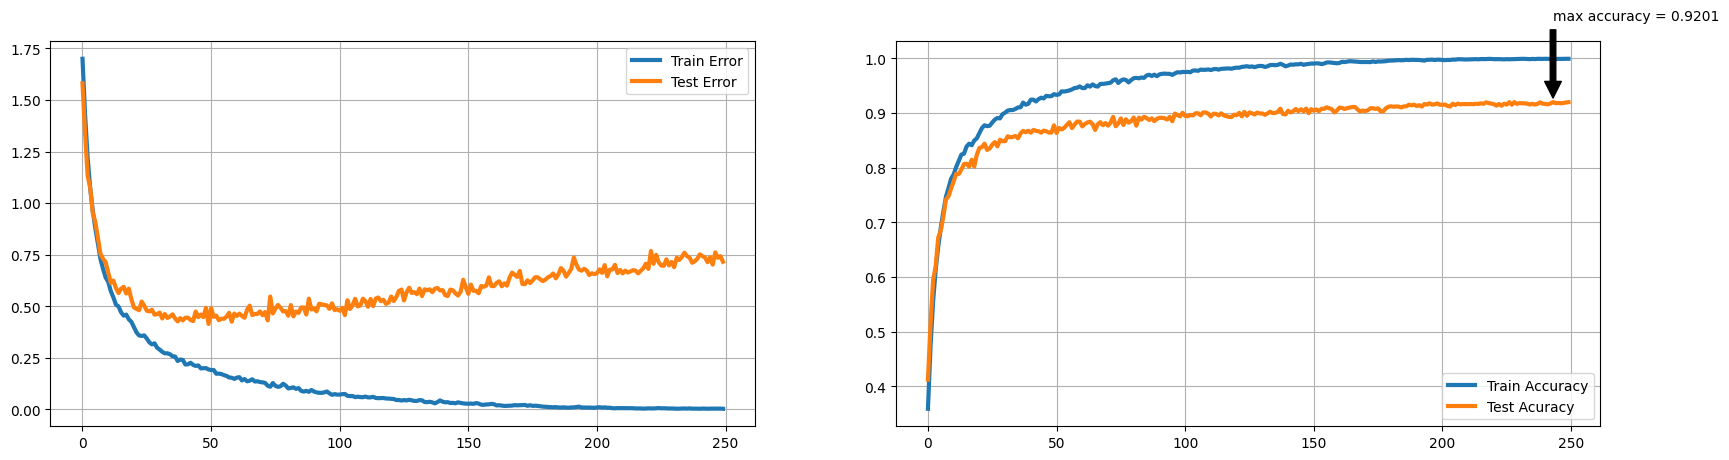

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
n = len(training_loss)
ax1.plot(range(n), training_loss, '-', linewidth='3', label='Train Error')
ax1.plot(range(n), testing_loss, '-', linewidth='3', label='Test Error')
ax2.plot(range(n), training_accuracy, '-', linewidth='3', label='Train Accuracy')
ax2.plot(range(n), testing_accuracy, '-', linewidth='3', label='Test Acuracy')
ax2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()
f.savefig("./train_test_curve.png")